In [1]:
"""
news_classifier/
├── main.py          # Main pipeline (train & evaluate)
├── data_loader.py   # Dataset loading & preprocessing
├── model.py         # Transformer-based classifier
├── train.py         # Training loop (with saving)
├── evaluate.py      # Evaluation logic
├── infer.py         # Inference script
├── utils.py         # Helpers (e.g., plots, save/load model)
└── models/          # Stores saved models
    └── news_bert.pth
""";

In [2]:
%%writefile data_loader.py
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader


class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        x = {key: val.squeeze(0) for key, val in encoding.items()}
        y = torch.tensor(label, dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.texts)


def load_data(file_path, tokenizer, test_size, rnd_seed=27):
    df = pd.read_csv(file_path)
    df.columns = ['headline', 'category', 'publisher', 'hostname']

    # Encode categories to numerical values.
    le = LabelEncoder()
    df['category'] = le.fit_transform(df['category'])

    X_train, X_test, y_train, y_test = train_test_split(df['headline'],
                                                        df['category'],
                                                        test_size=test_size,
                                                        random_state=rnd_seed)

    dataset_train = NewsDataset(X_train.tolist(), y_train.tolist(), tokenizer)
    dataset_test = NewsDataset(X_test.tolist(), y_test.tolist(), tokenizer)

    return dataset_train, dataset_test, le


Writing data_loader.py


In [3]:
%%writefile model.py
import torch
import torch.nn as nn

from transformers import AutoModel


class NewsClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(outputs.pooler_output)


Writing model.py


In [4]:
%%writefile train.py
import math
import logging
from tqdm import tqdm

import torch
import torch.nn as nn

from evaluate import evaluate
from utils import save_model


logging.basicConfig(level=logging.INFO)

def train(model, train_loader, test_loader, criterion, optimizer, tokenizer, label_encoder, num_epochs, device):
    model.to(device)

    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    for epoch in range(1, num_epochs + 1):
        # loop = tqdm(range(1, num_epochs + 1), desc=f'Epoch {epoch}/{num_epochs}', leave=True)
        model.train()
        running_loss, correct, total = 0, 0, 0

        # Automatically determine a reasonable log frequency
        if len(train_loader) <= 50:
            log_every = 1  # Log every batch for very small datasets
        elif len(train_loader) <= 500:
            log_every = max(1, len(train_loader) // 10)  # About 10 logs per epoch
        else:
            log_every = max(1, len(train_loader) // 20)  # About 20 logs for large datasets

        num_batches = math.ceil(len(train_loader.dataset) / train_loader.batch_size)
        for batch_idx, (inputs, labels) in enumerate(train_loader, start=1):
            inputs = {key: val.to(device) for key, val in inputs.items() if key != 'token_type_ids'}
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Log periodically based on dynamically calculated log_every
            if batch_idx % log_every == 0 or batch_idx == len(train_loader):
                current_loss = running_loss / total
                current_acc = correct / total
                # loop.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.4f}')
                tqdm.write(f'BATCH {batch_idx}/{num_batches} => Loss: {current_loss:.4f} - Acc {current_acc:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Evaluate on the test data
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        test_loss.append(val_loss)
        test_acc.append(val_acc)

        logging.info(
            f'\n*** EPOCH {epoch}/{num_epochs} ***\n'
            f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | '
            f'Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}'
        )
        logging.info('=' * 45)

    logging.info('*** Saving model, tokenizer & label encoder...')
    save_model(model, tokenizer, label_encoder, save_dir='models', model_name='news_bert.pth')

    return train_loss, train_acc, test_loss, test_acc


Writing train.py


In [5]:
%%writefile evaluate.py
import torch


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.inference_mode():
        for batch in loader:
            inputs, labels = batch
            # inputs = {key: val.to(device) for key, val in inputs.items()}
            inputs = {key: val.to(device) for key, val in inputs.items() if key != 'token_type_ids'}
            labels = labels.to(device)

            outputs = model(**inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader.dataset), correct / total


Writing evaluate.py


In [6]:
%%writefile infer.py
import logging
import argparse

import torch

from model import NewsClassifier
from utils import load_model

logging.basicConfig(level=logging.INFO)


def predict(headlines, num_classes, model_path='models/news_bert.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, tokenizer, label_encoder = load_model(NewsClassifier, 'bert-base-uncased', num_classes, model_path)

    model.to(device)
    model.eval()

    # If a single headline is given as string, make it a list of one:
    if isinstance(headlines, str):
        headlines = [headlines]
    # Preprocess input
    inputs = tokenizer(headlines, padding=True, truncation=True, max_length=128, return_tensors='pt')
    inputs = {key: val.to(device) for key, val in inputs.items() if key != 'token_type_ids'}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    categories = label_encoder.inverse_transform(predictions)
    category_map = {
    'b': 'business',
    't': 'tech & science',
    'm': 'health & medicine',
    'e': 'entertainment'
    }

    logging.info('Predicting sample headlines...')
    for headline, category in zip(headlines, categories):
        logging.info(f'Headline: {headline} => Predicted Category: {category_map[category]}')

if __name__ == '__main__':
    new_headlines = [
        'Apple launches new iPhone with AI capabilities',
        'Stock markets hit record high amid economic recovery',
        'Scientists discover new exoplanet in the Milky Way',
        'Sports team wins championship after thrilling final'
    ]
    logging.info('\n\nPredicting the sample headlines...')
    predict(new_headlines, 4)


Writing infer.py


In [7]:
%%writefile utils.py
import os
import pickle

import matplotlib.pyplot as plt

import torch


def save_model(model, tokenizer, label_encoder, save_dir='models', model_name='news_bert.pth'):
    os.makedirs(save_dir, exist_ok=True)

    # Save model and tokenizer
    save_path = os.path.join(save_dir, model_name)
    torch.save({
        'model_state_dict': model.state_dict(),
        'tokenizer': tokenizer,
        'label_encoder': label_encoder
    }, save_path)

    print(f'Model saved to {save_path}')


def load_model(model_class, model_name, num_classes, model_path='models/news_bert.pth'):
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

    model = model_class(model_name, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])

    tokenizer = checkpoint['tokenizer']
    label_encoder = checkpoint['label_encoder']

    print(f'Model loaded from {model_path}')
    return model, tokenizer, label_encoder


import matplotlib.pyplot as plt

def plot_curves(train_loss, train_acc, test_loss, test_acc, save_path='training_curves.png'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    epochs = range(1, len(train_loss) + 1)

    def plot_metric(ax, y_train, y_test, title, ylabel):
        ax.plot(epochs, y_train, label='Train')
        ax.plot(epochs, y_test, label='Test')
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(ylabel)
        ax.legend()

        # Show every other epoch (or at least two ticks)
        step = max(2, len(epochs) // 10)  # Adjust step size for large epochs
        ax.set_xticks(list(epochs)[::step])

    plot_metric(axes[0], train_loss, test_loss, 'Validation Curves', 'Loss')
    plot_metric(axes[1], train_acc, test_acc, 'Accuracy Progression', 'Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f'*** Plot saved to: {save_path} ***')

    plt.show()
    plt.close()  # Free memory


Writing utils.py


In [8]:
%%writefile main.py
import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer

from data_loader import load_data
from model import NewsClassifier
from train import train
from utils import plot_curves


def go():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_name = 'bert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    dataset_train, dataset_test, label_encoder = load_data('headlines.csv', tokenizer, test_size=.2)
    loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
    loader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

    model = NewsClassifier(model_name, num_classes=len(label_encoder.classes_))
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    train_loss, train_acc, test_loss, test_acc = train(model,
                                                       loader_train,
                                                       loader_test,
                                                       criterion,
                                                       optimizer,
                                                       tokenizer=tokenizer,
                                                       label_encoder=label_encoder,
                                                       num_epochs=2,
                                                       device=device)

    plot_curves(train_loss, train_acc, test_loss, test_acc)


if __name__ == '__main__':
    go()


Writing main.py


In [9]:
!python main.py

tokenizer_config.json: 100% 48.0/48.0 [00:00<00:00, 264kB/s]
config.json: 100% 570/570 [00:00<00:00, 3.52MB/s]
vocab.txt: 100% 232k/232k [00:00<00:00, 1.43MB/s]
tokenizer.json: 100% 466k/466k [00:00<00:00, 2.82MB/s]
2025-03-04 19:13:56.341514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741115636.373523     373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741115636.382983     373 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 19:13:56.416370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

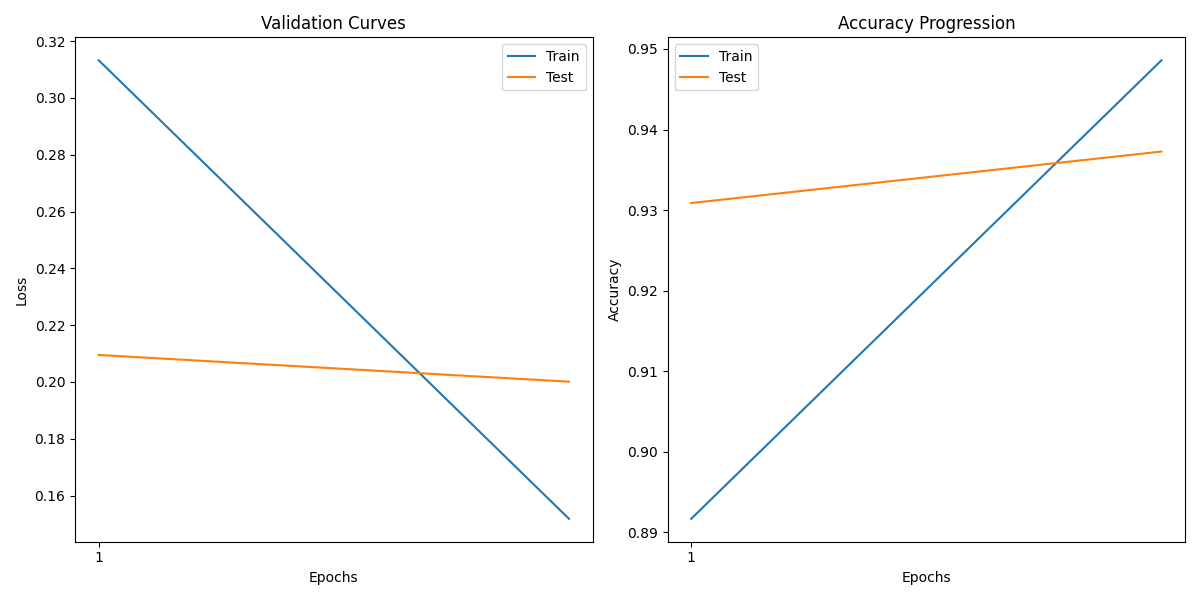

In [10]:
from IPython.display import Image, display

display(Image(filename='training_curves.png'))

In [11]:
!python infer.py

INFO:root:

Predicting the sample headlines...
/content/utils.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.dev

In [12]:
%%writefile predict1.py

from infer import predict

headline = 'Sports team wins championship after thrilling final'
predict(headline, num_classes=4)

Writing predict1.py


In [13]:
!python predict1.py

/content/utils.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
2025-03-04 19:39:33.374189: E exter

In [14]:
# why? Figured it out?
from infer import predict

headline = 'Sports team wins championship after thrilling final'
predict(headline, num_classes=4)

/content/utils.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
/usr/local/lib/python3.11/dist-pack

Model loaded from models/news_bert.pth
